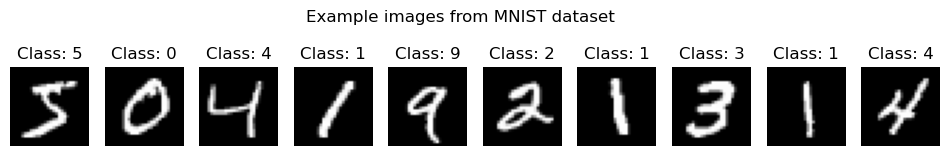

img size: (28,28)


In [1]:
import torch
import numpy as np
from torchvision.transforms import v2, ToPILImage
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.v2.functional as F
from utils import MAE_Encoder, MAE_Decoder
from masking import saliency_guided_masking

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = v2.Compose([v2.PILToTensor()])
# Load MNIST dataset
X_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
X_test = datasets.MNIST('../data', train=False, download=True, transform=transform)

# Visualize some samples
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    input, classes = X_train[i]
    plt.imshow(input.squeeze(), cmap="gray")
    plt.title(f"Class: {classes}")
    plt.axis("off")

plt.suptitle("Example images from MNIST dataset")
plt.show()

img_size = 28
patch_size = 4
print(f"img size: ({img_size},{img_size})")

def extract_patches(img, patch_size):
    imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
    return imgp

# Returns a tensor of size [batch_size, num_patches, patch_size, patch_size]
def collate_fn(batch):
    images, _ = zip(*batch)
    imgs = np.array([np.asarray(image) for image in images]) / 255.0
    imgs = torch.tensor(imgs, dtype=torch.float32)
    imgs_orig = imgs.clone().reshape(imgs.shape[0], -1)
    imgs = torch.cat([extract_patches(img, patch_size) for img in imgs], dim=1)
    imgs = imgs.permute(1, 0, 2, 3)
    return imgs, imgs_orig.reshape(-1, 1, 28, 28)

# DataLoader creation
batch_size = 16
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [2]:
# Get random sample
sample = next(iter(test_loader))
img, img_orig = sample
encoder = MAE_Encoder(img_size=img_size, mask_ratio=0.75)
decoder = MAE_Decoder(img_size=img_size)

print(img_orig.shape)
encoded, backward_indexes = encoder(img_orig)
dec_img, mask = decoder(encoded, backward_indexes)

torch.Size([16, 1, 28, 28])
torch.Size([16, 49, 192])
torch.Size([16, 12, 192])
torch.Size([12, 16, 192])
torch.Size([16, 49])
torch.Size([49, 16])


torch.Size([49, 16])
torch.Size([13, 16, 192])
torch.Size([49, 16, 192])

torch.Size([16, 49, 49])
torch.Size([16, 49, 49])
torch.Size([16, 49, 49])
tensor(0.6562)
torch.Size([16, 16, 192])


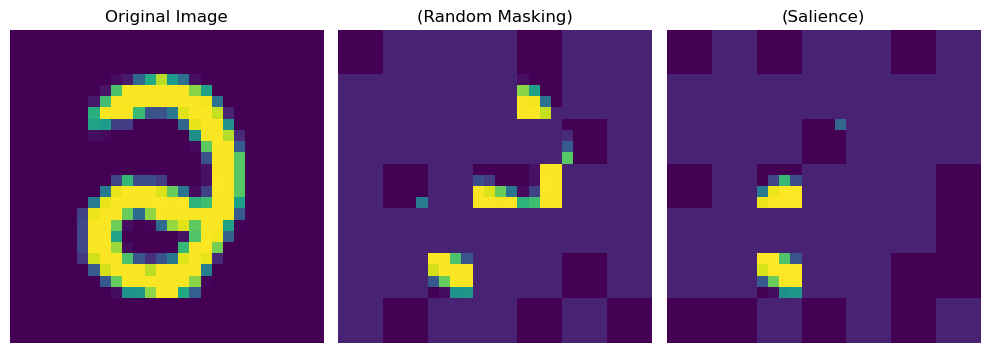

In [3]:
from einops import repeat, rearrange
from einops.layers.torch import Rearrange


print(backward_indexes.shape)
print(encoded.shape)
# Random masking
masked_im = img_orig[0, 0].clone()  
masked_im[mask[0, 0] != 0] = 0.1

base_masking = 0.75
mask_ratio_var = 0.15
delta = 0.1

patches = encoder.patch_embed(img_orig)
print(patches.shape, end="\n\n")   

x, mask, ids_restore = saliency_guided_masking(patches, base_masking, mask_ratio_var, delta)

encoded = rearrange(x, 't b e -> b t e')
ids_restore = rearrange(ids_restore, 'b t -> t b')
print(x.shape)

dec_img, mask = decoder(encoded, ids_restore)
masked_im2 = img_orig[0, 0].clone()
masked_im2[mask[0, 0] != 0] = 0.1


# Plot the original and masked images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_orig[0][0])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(masked_im)
plt.title("(Random Masking)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(masked_im2)
plt.title("(Salience)")
plt.axis("off")

# Add spacing between the plots for better readability
plt.tight_layout()
plt.show()

# Plankton images

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

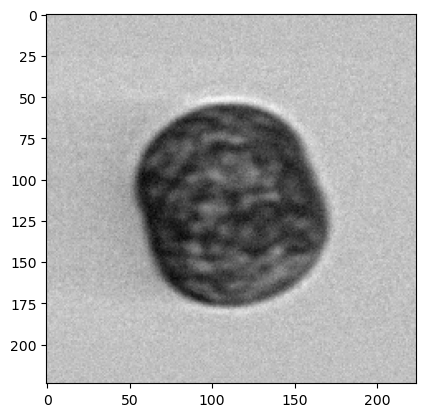

In [5]:
from PIL import Image
from torchvision.datasets import ImageFolder

transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
                        v2.Grayscale(num_output_channels=1), 
                        AddGaussianNoise(0, 0.025),
                        # v2.ColorJitter(brightness=(0, 0.5), hue=(0, 0.2))
                        ])

plankton_dataset = ImageFolder("./data/", transform=transform)
train_loader = torch.utils.data.DataLoader(plankton_dataset, batch_size=5, shuffle=True, num_workers=2)

# Get random image
sample = next(iter(train_loader))
img, label = sample

plt.imshow(img[0, 0], cmap="gray")
plt.show()

torch.Size([2, 196, 192])
torch.Size([2, 49, 192])
torch.Size([49, 2, 192])
torch.Size([2, 196])
torch.Size([196, 2])
random masking: 0.75
torch.Size([2, 196, 192])
torch.Size([2, 49, 192])
salience masking2: 0.7551020383834839


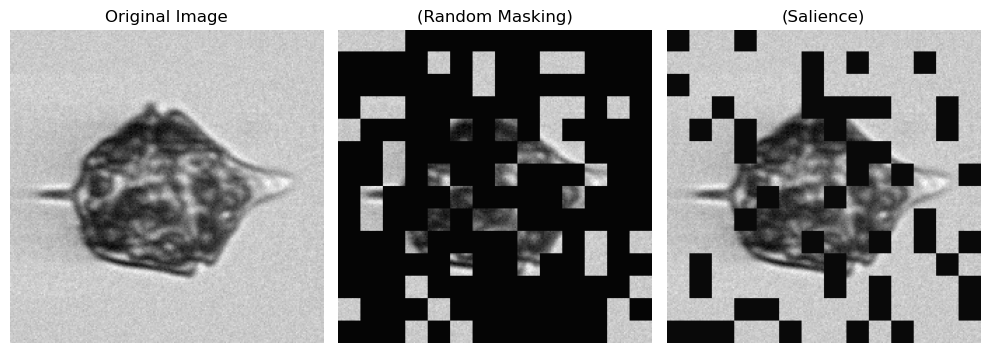

In [9]:

import torch
import torch.nn as nn
from einops import repeat, rearrange


def take_indexes(sequences, indexes):
    print(sequences.shape)
    print(indexes.shape)
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))


def saliency_guided_masking(x, base_mask_ratio, mask_ratio_var, delta):
    # Input shape: (num_patches, batch_size, embed_dim)
    N, B, C = x.shape 
    
    x = rearrange(x, 'n b c -> b n c')
    aff = torch.matmul(x, x.permute(0, 2, 1))
    print(aff.shape)
    aff = torch.einsum('nip,njp->nij', x, x)
    print(aff.shape)
    aff = nn.functional.softmax(aff, dim=2)
    
    print(aff.shape)
    aff_sum = torch.sum(aff, dim=1)

    aff_sum_normalized = (aff_sum - aff_sum.min(dim=1, keepdim=True)[0]) / \
                            (aff_sum.max(dim=1, keepdim=True)[0] - aff_sum.min(dim=1, keepdim=True)[0])

    y = (aff_sum_normalized > delta).sum(dim=1)

    y_max = aff_sum_normalized.size(1)
    y_normalized = y.float().mean() / y_max

    dynamic_mask_ratios = base_mask_ratio - mask_ratio_var + 2 * mask_ratio_var * y_normalized
    print(dynamic_mask_ratios)
    len_keep = int(N * (1- dynamic_mask_ratios))

    noise = torch.rand(B, N , device=x.device) / 2
    saliency_guided_noise = aff_sum_normalized + noise

    ids_shuffle = torch.argsort(saliency_guided_noise, dim=1)
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, C))

    ids_restore = rearrange(ids_restore, 'b t -> t b')
    x_masked = rearrange(x_masked, 't b e -> b t e')
    return x_masked,  ids_restore


def random_masking(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    x = rearrange(x, 'n b c -> b n c')
    print(x.shape)
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))
    
    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
    
    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    print(x_masked.shape)
    x_masked = rearrange(x_masked, 'b n c-> n b c ')
    ids_restore = rearrange(ids_restore, 'b n-> n b ')
    # generate the binary mask: 0 is keep, 1 is remove
    # mask = torch.ones([N, L], device=x.device)
    # mask[:, :len_keep] = 0
    # # unshuffle to get the binary mask
    # mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, ids_restore


encoder = MAE_Encoder(img_size=224, patch_size=16,  mask_ratio=0.75)
decoder = MAE_Decoder(img_size=224, patch_size=16)

encoded, backward_indexes = encoder(img)
dec_img, mask = decoder(encoded, backward_indexes)

sample = next(iter(train_loader))
img, label = sample
# Random masking
masked_im = img[0, 0].clone()  
masked_im[mask[0, 0] != 0] = 0.1

# 
base_masking = 0.75
mask_ratio_var = 0.1
delta = 0.05

print(f"random masking: {mask.sum()/mask.numel()}")
patches = encoder.patch_embed(img)
encoded, ids_restore = random_masking(patches, base_masking)

# encoded, ids_restore = saliency_guided_masking(patches, base_masking, mask_ratio_var, delta)

dec_img, mask2 = decoder(encoded, ids_restore)
print(f"salience masking2: {mask2.sum()/mask2.numel()}")
masked_im2 = img[0, 0].clone()

masked_im2[mask2[0, 0] == 0] = 0.1

# Plot the original and masked images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img[0][0], cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(masked_im, cmap="gray")
plt.title("(Random Masking)")
plt.axis("off")


plt.subplot(1, 3, 3)
plt.imshow(masked_im2, cmap="gray")
plt.title("(Salience)")
plt.axis("off") 

# Add spacing between the plots for better readability
plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn
from einops import repeat, rearrange


patches = encoder.patch_embed(img)
print(patches.shape)

# patches = rearrange(patches, 't b c -> b t c')
x, mask, ids_restore = saliency_guided_masking(patches, base_masking, mask_ratio_var, delta)
print(x.shape)
ids_restore = rearrange(ids_restore, 'b t -> t b')

dec_img, mask = decoder(encoded, ids_restore)
masked_im2 = img[0, 0].clone()
masked_im2[mask[0, 0] != 1] = 0.1

torch.Size([196, 2, 192])
torch.Size([2, 196, 196])
torch.Size([2, 196, 196])
torch.Size([2, 196, 196])
tensor(0.2939)


ValueError: not enough values to unpack (expected 3, got 2)